# TD learning

在悬崖漫步环境下尝试 Sarsa 算法

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库

In [9]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0
        self.y = nrow - 1
        
    def step(self, action):
        """
        input: action index
        output: next_state, reward, done
        """
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1,max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1,max(0, self.y + change[action][1]))
        next_state = self.x + self.y * self.ncol
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x
        

实现 SARSA 算法

In [10]:
class Sarsa:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
    
    def take_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):
        """
        Return a action list.
        The best action's index is 1, others are 0.
        """
        Q_max = np.argmax(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action): 
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
        
    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0][a0] += self.alpha * td_error
        

Iteration: 9: 100%|██████████| 50/50 [00:00<00:00, 17229.31it/s, episode=500, return=-18.900]


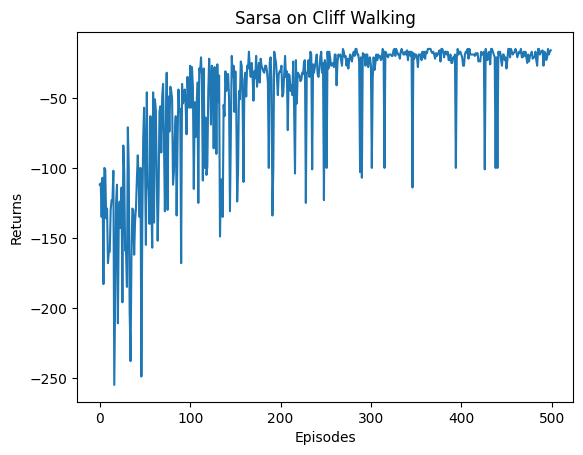

In [11]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

return_list = [] 

for i in range(10):
    with tqdm(total = int(num_episodes / 10), desc="Iteration: %d"%i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
                
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

            

打印策略：

In [12]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo 
oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo 
oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo oooo 
oooo **** **** **** **** **** **** **** **** **** **** EEEE 


接下来实现 **多步 SARSA** 算法

In [ ]:
class nstep_Sarsa:
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.n = n
        self.state_list = []
        self.action_list = []
        self.reward_list = []

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):  
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:
            G = self.Q_table[s1, a1]
            for i in reversed(range(self.n)):
                G = G * self.gamma + self.reward_list[i]
                if done and i > 0:  # 这里不包括 i = 0 的情况，因为默认 i=0 在循环之外进行更新，避免重复更新
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s][a] += self.alpha * (G - self.Q_table[s, a])
            
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            self.Q_table[s][a] += self.alpha * (G - self.Q_table[s, a])
        
        if done:
            self.action_list = []
            self.state_list = []
            self.reward_list = []
            
            

可视化效果

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 16387.84it/s, episode=500, return=-19.100]


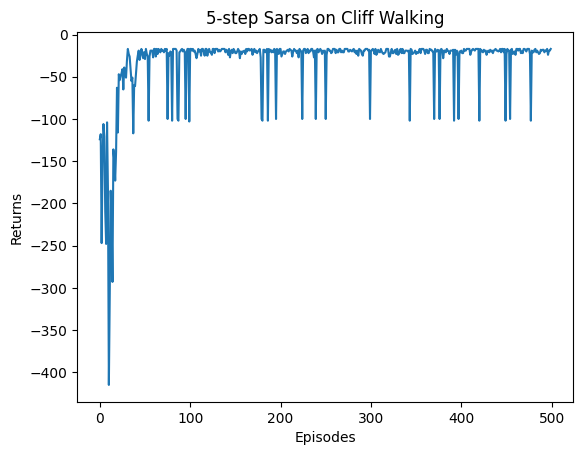

In [24]:
np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n=n_step, ncol=ncol, nrow=nrow, epsilon=epsilon, alpha=alpha, gamma=gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action,
                             done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

Q-learning 算法

In [ ]:
class QLearning:
    def __init__(self, ncol, nrow, gamma, alpha, epsilon, n_action = 4):
        self.Q_table = np.zeros([ncol * nrow, n_action])
        self.n_action = n_action
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        
    def take_action(self, state):
        if np.random.rand() < epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        
        return action

    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * np.max(self.Q_table[s1]) - self.Q_table[s0][a0]
        self.Q_table[s0][a0] += self.alpha * td_error
        


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 15088.51it/s, episode=500, return=-46.000]


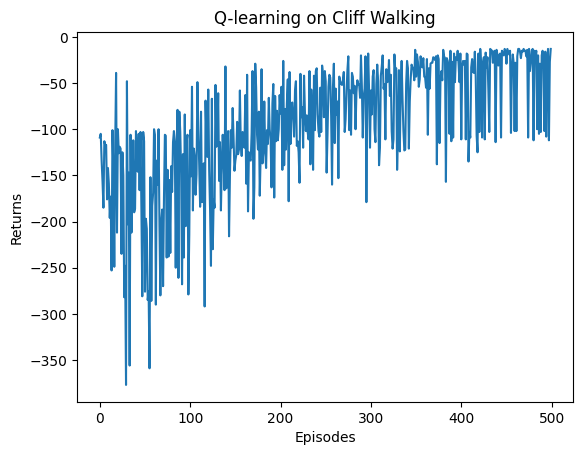

Q-learning算法最终收敛得到的策略为：
^ooo ^ooo ^ooo ooo> ^ooo ^ooo ^ooo ^ooo ooo> ovoo ovoo oo<o 
ovoo ooo> ooo> ovoo ooo> ooo> ooo> ooo> ooo> ovoo ^ooo ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [33]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])